In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_regulation/utils/')
from utils_functions import *
from statsmodels.stats.multitest import multipletests


from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
weyn_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_psi.tab', sep='\t', index_col=0)
weyn_ds = get_averages_bulk(weyn_psi)

hubbard_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Hubbard_pvals.tab', sep='\t', index_col=0)
hubbard_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Hubbard_fdr.tab', sep='\t', index_col=0)
hubbard_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Hubbard_psi.tab', sep='\t', index_col=0)
hubbard_ds = get_averages_bulk(hubbard_psi)

song_bulk_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/song_bulk_pvals.tab', sep='\t', index_col=0)
song_bulk_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/song_bulk_fdr.tab', sep='\t', index_col=0)
song_bulk_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/song_bulk_psi.tab', sep='\t', index_col=0)
song_bulk_ds = get_averages_bulk(song_bulk_psi)


In [3]:
chen_PSI = pd.read_csv('mesc_neurogenesis/data/preprocess/tables/psi.tab.gz', sep='\t', index_col=0)
chen_meta = pd.read_csv('mesc_neurogenesis/data/SraRunTable.txt.gz', sep='\t', index_col=5)
chen_psix = pd.read_csv('mesc_neurogenesis/psix_object/psix_results.tab.gz', sep='\t', index_col=0)

es2i = chen_meta.index[chen_meta.cell_type_s == 'ES2i'] & chen_PSI.columns
es = chen_meta.index[chen_meta.cell_type_s == 'ES'] & chen_PSI.columns
epi = chen_meta.index[chen_meta.cell_type_s == 'Epi'] & chen_PSI.columns
mn = chen_meta.index[chen_meta.cell_type_s == 'Motor neuron'] & chen_PSI.columns

chen_labels = [es2i, es, epi, mn]
from scipy.stats import kruskal

def run_kw(exon_psi, labels):
    kw_input = []
    for l in labels:
        kw_input.append(list(exon_psi.loc[l]))
        
    if len(labels) == 2:
        return kruskal(kw_input[0], kw_input[1], nan_policy='omit')
    if len(labels) == 3:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], nan_policy='omit')
    if len(labels) == 4:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], nan_policy='omit')
    if len(labels) == 5:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], nan_policy='omit')
    if len(labels) == 6:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], nan_policy='omit')
    
def run_kw_dset(psi_table, labels, exon_list):
    kw_output = pd.DataFrame()
    kw_score = []
    pvals = []
    for exon in exon_list:
        score, p = run_kw(psi_table.loc[exon], labels)
        kw_score.append(score)
        pvals.append(p)
    kw_output['KW_score'] = kw_score
    kw_output['pvals'] = pvals
    kw_output['qvals'] = multipletests(pvals, method='fdr_bh')[1]
    kw_output.index = exon_list
    return kw_output

chen_kw = run_kw_dset(chen_PSI, chen_labels, chen_psix.index)

chen_gearyc = pd.read_csv('mesc_neurogenesis/gearyc/gearyc.tab.gz', sep='\t', index_col=0)
chen_gearyc['qvals'] = multipletests(chen_gearyc.pvals, method='fdr_bh')[1]

In [4]:
one_v_one = 'mesc_neurogenesis/brie2/label_v_label/'

chen_0v1 = pd.read_csv(one_v_one + 'ES2i_v_Epi/brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)
chen_0v2 = pd.read_csv(one_v_one + 'ES2i_v_ES/brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)
chen_0v3 = pd.read_csv(one_v_one + 'ES2i_v_MN/brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)

chen_one_v_one = pd.DataFrame()
chen_one_v_one['0v1'] = chen_0v1.neuro_ELBO_gain
chen_one_v_one['0v2'] = chen_0v2.neuro_ELBO_gain
chen_one_v_one['0v3'] = chen_0v3.neuro_ELBO_gain
chen_ovo = chen_one_v_one.max(axis=1)

In [5]:
tiklova_PSI = pd.read_csv('mouse_brain_development/data/preprocess/tables/psi_3D.tab.gz', sep='\t', index_col=0)
tiklova_meta = pd.read_csv('mouse_brain_development/data/SraRunTable.txt.gz', sep=',', index_col=0)
tiklova_psix = pd.read_csv('mouse_brain_development/psix_3D/psix_results.tab.gz', sep='\t', index_col=0)

e13 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 13.5'] & tiklova_PSI.columns
e15 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 15.5'] & tiklova_PSI.columns
e18 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 18.5'] & tiklova_PSI.columns
p1 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 1'] & tiklova_PSI.columns
p7 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 7'] & tiklova_PSI.columns
p90 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 90'] & tiklova_PSI.columns

tiklova_labels = [e13, e15, e18, p1, p7, p90]
from scipy.stats import kruskal

def run_kw(exon_psi, labels):
    kw_input = []
    for l in labels:
        kw_input.append(list(exon_psi.loc[l]))
        
    if len(labels) == 2:
        return kruskal(kw_input[0], kw_input[1], nan_policy='omit')
    if len(labels) == 3:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], nan_policy='omit')
    if len(labels) == 4:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], nan_policy='omit')
    if len(labels) == 5:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], nan_policy='omit')
    if len(labels) == 6:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], nan_policy='omit')
    
def run_kw_dset(psi_table, labels, exon_list):
    kw_output = pd.DataFrame()
    kw_score = []
    pvals = []
    for exon in exon_list:
        score, p = run_kw(psi_table.loc[exon], labels)
        kw_score.append(score)
        pvals.append(p)
    kw_output['KW_score'] = kw_score
    kw_output['pvals'] = pvals
    kw_output['qvals'] = multipletests(pvals, method='fdr_bh')[1]
    kw_output.index = exon_list
    return kw_output

tiklova_kw = run_kw_dset(tiklova_PSI, tiklova_labels, tiklova_psix.index)

tiklova_gearyc = pd.read_csv('mouse_brain_development/gearyc/gearyc.tab.gz', sep='\t', index_col=0)
tiklova_gearyc['qvals'] = multipletests(tiklova_gearyc.pvals, method='fdr_bh')[1]

one_v_one = 'mouse_brain_development/brie2/'
tiklova_0v1 = pd.read_csv(one_v_one + 'brie_output_E13_v_E15/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v2 = pd.read_csv(one_v_one + 'brie_output_E13_v_E18/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v3 = pd.read_csv(one_v_one + 'brie_output_E13_v_P1/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v4 = pd.read_csv(one_v_one + 'brie_output_E13_v_P7/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v5 = pd.read_csv(one_v_one + 'brie_output_E13_v_P90/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)

tiklova_one_v_one = pd.DataFrame()
tiklova_one_v_one['0v1'] = tiklova_0v1.neuro_ELBO_gain
tiklova_one_v_one['0v2'] = tiklova_0v2.neuro_ELBO_gain
tiklova_one_v_one['0v3'] = tiklova_0v3.neuro_ELBO_gain
tiklova_one_v_one['0v4'] = tiklova_0v4.neuro_ELBO_gain
tiklova_one_v_one['0v5'] = tiklova_0v5.neuro_ELBO_gain
tiklova_ovo = tiklova_one_v_one.max(axis=1)

In [6]:
song_PSI = pd.read_csv('ipsc_neurogenesis/data/preprocess/tables/psi.tab.gz', sep='\t', index_col=0)
song_meta = pd.read_csv('ipsc_neurogenesis/data/SraRunTable.txt.gz', sep='\t', index_col=7)
song_psix = pd.read_csv('ipsc_neurogenesis/psix_object/psix_results.tab.gz', sep='\t', index_col=0)

ipsc = song_meta.index[song_meta.cell_type_s == 'Skin fibroblast-derived induced pluripotent cells (iPSCs)'] & song_PSI.columns
npc = song_meta.index[song_meta.cell_type_s == 'iPSC-derived neural progenitor cells'] & song_PSI.columns
mn = song_meta.index[song_meta.cell_type_s == 'iPSC-derived motor neurons'] & song_PSI.columns

song_labels = [ipsc, npc, mn]
from scipy.stats import kruskal

def run_kw(exon_psi, labels):
    kw_input = []
    for l in labels:
        kw_input.append(list(exon_psi.loc[l]))
        
    if len(labels) == 2:
        return kruskal(kw_input[0], kw_input[1], nan_policy='omit')
    if len(labels) == 3:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], nan_policy='omit')
    if len(labels) == 4:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], nan_policy='omit')
    if len(labels) == 5:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], nan_policy='omit')
    if len(labels) == 6:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], nan_policy='omit')
    
def run_kw_dset(psi_table, labels, exon_list):
    kw_output = pd.DataFrame()
    kw_score = []
    pvals = []
    for exon in exon_list:
        score, p = run_kw(psi_table.loc[exon], labels)
        kw_score.append(score)
        pvals.append(p)
    kw_output['KW_score'] = kw_score
    kw_output['pvals'] = pvals
    kw_output['qvals'] = multipletests(pvals, method='fdr_bh')[1]
    kw_output.index = exon_list
    return kw_output

song_kw = run_kw_dset(song_PSI, song_labels, song_psix.index)

song_gearyc = pd.read_csv('ipsc_neurogenesis/gearyc/gearyc.tab.gz', sep='\t', index_col=0)
song_gearyc['qvals'] = multipletests(song_gearyc.pvals, method='fdr_bh')[1]

In [7]:
one_v_one = 'ipsc_neurogenesis/brie2/'

song_0v1 = pd.read_csv(one_v_one + 'iPSC_v_NPC/brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)
song_0v2 = pd.read_csv(one_v_one + 'iPSC_v_MN/brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)

song_one_v_one = pd.DataFrame()
song_one_v_one['0v1'] = song_0v1.neuro_ELBO_gain
song_one_v_one['0v2'] = song_0v2.neuro_ELBO_gain
song_ovo = song_one_v_one.max(axis=1)

100%|██████████| 200/200 [00:02<00:00, 79.48it/s]


Text(0.5, 1.0, 'Method comparison, Tiklova dataset')

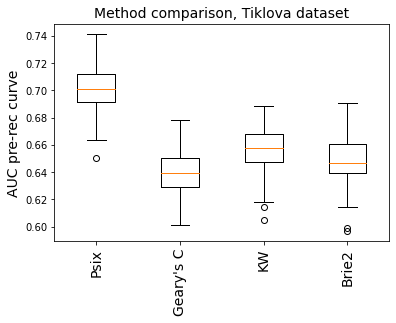

In [8]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index & tiklova_gearyc.index & tiklova_kw.index & tiklova_ovo.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
brie_auc = []

for sample in tqdm(range(200)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    c_y = list(tiklova_gearyc.loc[pos_choice].C_score) + list(tiklova_gearyc.loc[neg_choice].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    gearyc_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].psix_score) + list(tiklova_psix.loc[neg_choice].psix_score)
#     psix_y = list((tiklova_psix.loc[pos_choice].qvals <= 0.05).astype(int)) + list((tiklova_psix.loc[neg_choice].qvals <= 0.05).astype(int))
    pre, rec, thres = precision_recall_curve(y, psix_y)
    psix_auc.append(auc(rec, pre))
    

#     kw_y = list((tiklova_kw.loc[pos_choice].qvals <= 0.05).astype(int)) + list((tiklova_kw.loc[neg_choice].qvals <= 0.05).astype(int))
#     kw_auc.append(precision_recall_curve(y, kw_y))
    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    

#     r_y = list((tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]<=0.05).astype(int)) + list((tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]]<=0.05).astype(int))
    r_y = list(tiklova_ovo.loc[pos_choice]) + list(tiklova_ovo.loc[neg_choice])
    pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in tiklova_ovo.index]) + [0]*len([x for x in neg_choice if x in tiklova_ovo.index]), r_y)
    brie_auc.append(auc(rec, pre))
    #####


tiklova_boxplots = [ psix_auc, gearyc_auc, kw_auc, brie_auc]


bp = plt.boxplot(tiklova_boxplots)


plt.xticks(np.arange(1, 5), 
           ['Psix', "Geary's C", 'KW', 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Tiklova dataset', fontsize=14)

100%|██████████| 200/200 [00:02<00:00, 82.34it/s]


Text(0.5, 1.0, 'Method comparison, chen dataset')

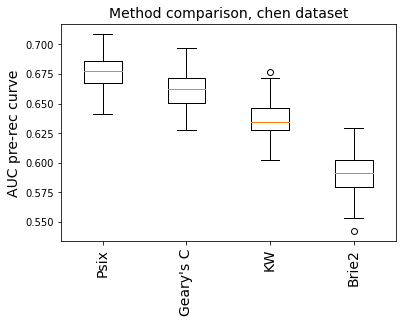

In [9]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

hubbard_pos = hubbard_fdr.index[(hubbard_ds.max(axis=1) >= 0.2) & (hubbard_fdr.min(axis=1) <= 0.05)]
hubbard_neg = hubbard_fdr.index[(hubbard_ds.max(axis=1) < 0.2) | (hubbard_fdr.min(axis=1) > 0.05)]

exons = chen_psix.index & chen_gearyc.index & chen_kw.index & chen_ovo.index
exons_pos = hubbard_pos & exons
exons_neg = hubbard_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
brie_auc = []

for sample in tqdm(range(200)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    c_y = list(chen_gearyc.loc[pos_choice].C_score) + list(chen_gearyc.loc[neg_choice].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    gearyc_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(chen_psix.loc[pos_choice].psix_score) + list(chen_psix.loc[neg_choice].psix_score)
#     psix_y = list((chen_psix.loc[pos_choice].qvals <= 0.05).astype(int)) + list((chen_psix.loc[neg_choice].qvals <= 0.05).astype(int))
    pre, rec, thres = precision_recall_curve(y, psix_y)
    psix_auc.append(auc(rec, pre))
    

#     kw_y = list((chen_kw.loc[pos_choice].qvals <= 0.05).astype(int)) + list((chen_kw.loc[neg_choice].qvals <= 0.05).astype(int))
#     kw_auc.append(precision_recall_curve(y, kw_y))
    kw_y = list(chen_kw.loc[pos_choice].KW_score) + list(chen_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    

#     r_y = list((chen_ovo.loc[[x for x in pos_choice if x in chen_ovo.index]]<=0.05).astype(int)) + list((chen_ovo.loc[[x for x in neg_choice if x in chen_ovo.index]]<=0.05).astype(int))
    r_y = list(chen_ovo.loc[pos_choice]) + list(chen_ovo.loc[neg_choice])
    pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in chen_ovo.index]) + [0]*len([x for x in neg_choice if x in chen_ovo.index]), r_y)
    brie_auc.append(auc(rec, pre))
    #####


chen_boxplots = [ psix_auc, gearyc_auc, kw_auc, brie_auc]


bp = plt.boxplot(chen_boxplots)


plt.xticks(np.arange(1, 5), 
           ['Psix', "Geary's C", 'KW', 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, chen dataset', fontsize=14)

100%|██████████| 200/200 [00:02<00:00, 83.57it/s]


Text(0.5, 1.0, 'Method comparison, song dataset')

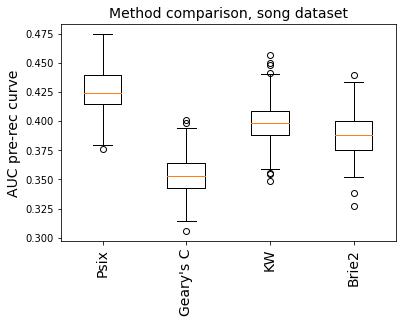

In [10]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# song_psix = pd.read_csv('~/sc_splicing_regulation/psix_runs/song.scores.txt', sep='\t', index_col=0)
# song_psix['psix_score'] = song_psix.L_score

song_bulk_pos = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) >= 0.2) & (song_bulk_fdr.min(axis=1) <= 0.01)]
song_bulk_neg = song_bulk_fdr.index[(song_bulk_ds.max(axis=1) < 0.2) | (song_bulk_fdr.min(axis=1) > 0.01)]

exons = song_psix.index & song_gearyc.index & song_kw.index & song_ovo.index
exons_pos = song_bulk_pos & exons
exons_neg = song_bulk_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
brie_auc = []

for sample in tqdm(range(200)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    c_y = list(song_gearyc.loc[pos_choice].C_score) + list(song_gearyc.loc[neg_choice].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    gearyc_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(song_psix.loc[pos_choice].psix_score) + list(song_psix.loc[neg_choice].psix_score)
#     psix_y = list((song_psix.loc[pos_choice].qvals <= 0.05).astype(int)) + list((song_psix.loc[neg_choice].qvals <= 0.05).astype(int))
    pre, rec, thres = precision_recall_curve(y, psix_y)
    psix_auc.append(auc(rec, pre))
    

#     kw_y = list((song_kw.loc[pos_choice].qvals <= 0.05).astype(int)) + list((song_kw.loc[neg_choice].qvals <= 0.05).astype(int))
#     kw_auc.append(precision_recall_curve(y, kw_y))
    kw_y = list(song_kw.loc[pos_choice].KW_score) + list(song_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    

#     r_y = list((song_ovo.loc[[x for x in pos_choice if x in song_ovo.index]]<=0.05).astype(int)) + list((song_ovo.loc[[x for x in neg_choice if x in song_ovo.index]]<=0.05).astype(int))
    r_y = list(song_ovo.loc[pos_choice]) + list(song_ovo.loc[neg_choice])
    pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in song_ovo.index]) + [0]*len([x for x in neg_choice if x in song_ovo.index]), r_y)
    brie_auc.append(auc(rec, pre))
    #####


song_boxplots = [ psix_auc, gearyc_auc, kw_auc, brie_auc]


bp = plt.boxplot(song_boxplots)


plt.xticks(np.arange(1, 5), 
           ['Psix', "Geary's C", 'KW', 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, song dataset', fontsize=14)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


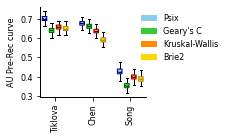

In [30]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8/2.4, 4/2.4))
gs = GridSpec(1,7)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4])
ax_2 = fig.add_subplot(gs[0,4:7])# option 1, specify props dictionaries

ax.boxplot([tiklova_boxplots[0], chen_boxplots[0], song_boxplots[0]], positions=[1,5,9], notch=True, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='navy'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='navy'), showfliers=False
            )

ax.boxplot([tiklova_boxplots[2], chen_boxplots[2], song_boxplots[2]], positions=[2.5,6.5,10.5], notch=True, patch_artist=True,
            boxprops=dict(facecolor='darkorange', color='darkred'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkred'), showfliers=False
            )

ax.boxplot([tiklova_boxplots[1], chen_boxplots[1], song_boxplots[1]], positions=[1.75,5.75,9.75], notch=True, patch_artist=True,
            boxprops=dict(facecolor='limegreen', color='darkgreen'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkgreen'), showfliers=False
            )

ax.boxplot([tiklova_boxplots[3], chen_boxplots[3], song_boxplots[3]], positions=[3.25,7.25,11.25], notch=True, patch_artist=True,
            boxprops=dict(facecolor='gold', color='darkgoldenrod'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkgoldenrod'), showfliers=False
            )

ax.set_xticks([2.125, 6.125, 10.125])
ax.set_xticklabels(['Tiklova', 'Chen', 'Song'], size=8, rotation=90)
# ax.set_xlabel('Capture efficiency', size=18)

ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
ax.set_yticklabels(['0.3', '0.4', '0.5', '0.6', '0.7'], size=8)
ax.set_ylabel('AU Pre-Rec curve', size=8)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax_2.set_xlim([0, 0])

ax_2.hist([-1, -1], color='skyblue', label='Psix')
ax_2.hist([-1, -1], color='limegreen', label="Geary's C")
ax_2.hist([-1, -1], color='darkorange', label='Kruskal-Wallis')

ax_2.hist([-1, -1], color='gold', label="Brie2")

ax_2.spines["bottom"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["right"].set_visible(False)
ax_2.spines["left"].set_visible(False)

ax_2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    right=False,
    left=False, # ticks along the top edge are off
    labelleft=False,
    labelbottom=False)

ax_2.legend(frameon=False, fontsize=8)
plt.savefig('simulations/plots/tools_data_auc.png', bbox_inches='tight', res=20000, dpi =2000)

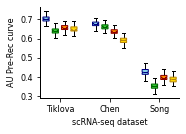

In [31]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6/2.4, 4/2.4))
ax = fig.add_subplot(111)

ax.boxplot([tiklova_boxplots[0], chen_boxplots[0], song_boxplots[0]], positions=[1,5,9], notch=True, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='navy'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='navy'), showfliers=False
            )

ax.boxplot([tiklova_boxplots[2], chen_boxplots[2], song_boxplots[2]], positions=[2.5,6.5,10.5], notch=True, patch_artist=True,
            boxprops=dict(facecolor='darkorange', color='darkred'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkred'), showfliers=False
            )

ax.boxplot([tiklova_boxplots[1], chen_boxplots[1], song_boxplots[1]], positions=[1.75,5.75,9.75], notch=True, patch_artist=True,
            boxprops=dict(facecolor='limegreen', color='darkgreen'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkgreen'), showfliers=False
            )

ax.boxplot([tiklova_boxplots[3], chen_boxplots[3], song_boxplots[3]], positions=[3.25,7.25,11.25], notch=True, patch_artist=True,
            boxprops=dict(facecolor='gold', color='darkgoldenrod'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkgoldenrod'), showfliers=False
            )

ax.set_xticks([2.125, 6.125, 10.125])
ax.set_xticklabels(['Tiklova', 'Chen', 'Song'], size=8, rotation=0)
ax.set_xlabel('scRNA-seq dataset', size=8)

ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
ax.set_yticklabels(['0.3', '0.4', '0.5', '0.6', '0.7'], size=8)
ax.set_ylabel('AU Pre-Rec curve', size=8)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig('simulations/plots/scrnaseq_data_auc.png', bbox_inches='tight', res=20000, dpi =2000)

In [12]:
tiklova_gearyc

,C_score,pvals,qvals
Aamdc_9,0.000890,0.967016,1.000000
Aamdc_10,0.092443,0.012494,0.029630
Aasdhppt_2,0.191759,0.000500,0.001635
Abat_3,0.436261,0.000500,0.001635
Abca3_4,0.014965,0.423788,0.633104
...,...,...,...
Zscan18_1,-0.035316,1.000000,1.000000
Zyx_1,0.017033,0.161919,0.278816
l7Rn6_1,0.089549,0.000500,0.001635
l7Rn6_3,-0.041635,1.000000,1.000000


In [13]:
weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index & tiklova_gearyc.index & tiklova_kw.index & tiklova_ovo.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


In [14]:
exons_neg

Index(['Ppfia2_5', 'Lin7a_1', 'Lin7a_2', 'Syt1_3', 'Thap2_1', 'Cnot2_32',
       'Cpsf6_nmdSE_1', 'Cpsf6_5', 'Mdm2_2', 'Mdm2_3',
       ...
       'Fhl1_2', 'Fgf13_1', 'Taz_3', 'Dkc1_4', 'Wdr45_4', 'Wdr45_6', 'Tbl1x_1',
       'Tfe3_1', 'Gripap1_5', 'Rbm3_nmdSE_1'],
      dtype='object', length=1141)

In [15]:
exons_neg[tiklova_psix.loc[exons_neg].qvals >= 0.25] & exons_neg[tiklova_kw.loc[exons_neg].qvals <= 0.05]

Index(['Syt1_3', 'Mdm2_3', 'Sobp_8', 'Dip2a_1', 'Pcbp3_6', 'Izumo4_2',
       'Gpatch8_2', 'Gosr2_1', 'Cyb561_3', 'Atp5h_4',
       ...
       'Nme6_11', 'Chordc1_1', 'Zfp846_nmdSE_1', 'Lrrc49_3', 'Tcf12_7',
       'Zmym3_7', 'Atrx_10', 'Usp9x_4', 'Armcx1_1', 'Gria3_nmdSE_1'],
      dtype='object', length=141)

In [16]:
aver = exons_pos[tiklova_psix.loc[exons_pos].qvals <=0.05] & exons_pos[tiklova_kw.loc[exons_pos].qvals >= 0.05]

In [17]:
tiklova_psix.loc[aver].sort_values('psix_score')

,psix_score,pvals,qvals
Hp1bp3_2,0.016095,0.015992,0.042194
Mapk8ip3_4,0.016719,0.015992,0.042194
Stx3_5,0.017425,0.010995,0.030594
Pgs1_3,0.017631,0.010995,0.030594
Inip_1,0.024750,0.003998,0.014023
Apeh_4,0.028108,0.006497,0.019622
Ctage5_8,0.028222,0.003998,0.014023
Gtf2ird1_5,0.029533,0.005997,0.019622
Cdc7_4,0.033703,0.016992,0.044493
Bcas3_5,0.033771,0.016992,0.044493


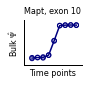

In [61]:
times = ['E14', 'E16', 'P0', 'P4', 'P7', 'P15', 'P30', 'P110', 'M21']
mean_ = []
for t in times:
    mean_.append(weyn_psi.loc['Mapt_1', [t+'_rep1', t+'_rep2']].mean())
fig = plt.figure(figsize=(2.5/2.4, 2/2.4))

ax = fig.add_subplot(111)

ax.scatter([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8],
            weyn_psi.loc['Mapt_1'], facecolors='none', edgecolors='navy', s=20, linewidth=1)
ax.plot([0, 1, 2, 3, 4, 5, 6, 7, 8], mean_, c='navy', linewidth=1.5)
ax.set_ylim((-0.15, 1.15))
ax.set_xlim((-1.5, 9))


# ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_xticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], size=18)
ax.set_xlabel('Time points', size=8)

# ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], size=8)
ax.set_ylabel('Bulk $\hat{\Psi}$', size=8)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title('Mapt, exon 10', size=8)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,
    left = False,
    right = False, # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
labelleft=False)

plt.savefig('simulations/plots/mapt_1_bulk.png', bbox_inches='tight', res=20000, dpi =2000)

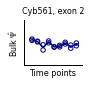

In [62]:



times = ['E14', 'E16', 'P0', 'P4', 'P7', 'P15', 'P30', 'P110', 'M21']
mean_ = []
for t in times:
    mean_.append(weyn_psi.loc['Cyb561_3', [t+'_rep1', t+'_rep2']].mean())
fig = plt.figure(figsize=(2.5/2.4, 2/2.4))

ax = fig.add_subplot(111)

ax.scatter([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8],
            weyn_psi.loc['Cyb561_3'], facecolors='none', edgecolors='navy', s=20, linewidth=1)
ax.plot([0, 1, 2, 3, 4, 5, 6, 7, 8], mean_, c='navy', linewidth=1.5)
ax.set_ylim((-0.15, 1.15))
ax.set_xlim((-1.5, 9))


# ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_xticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], size=18)
ax.set_xlabel('Time points', size=8)

# ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], size=8)
ax.set_ylabel('Bulk $\hat{\Psi}$', size=8)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title('Cyb561, exon 2', size=8)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,
    left = False,
    right = False, # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
labelleft=False)

plt.savefig('simulations/plots/Cyb561_3_bulk.png', bbox_inches='tight', res=20000, dpi =2000)

In [84]:
mean_

[0.6559999999999999,
 0.493,
 0.491,
 0.23600000000000002,
 0.209,
 0.33299999999999996,
 0.48100000000000004,
 0.40700000000000003,
 0.41600000000000004]

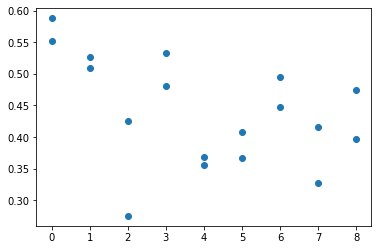

In [60]:
plt.scatter([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8],
            weyn_psi.loc['Cyb561_3'])

In [64]:
rd = pd.read_csv('mouse_brain_development/data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)

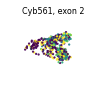

In [70]:
fig = plt.figure(figsize=(4/2.4, 3/2.5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, 
           c=tiklova_PSI.loc['Cyb561_3'], alpha=0.9, s=5, linewidth=0)


ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.axis("off")

ax.grid(False)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Cyb561, exon 2', fontsize=8)

plt.savefig('simulations/plots/Cyb561_3_sc.png', bbox_inches='tight', res=20000, dpi =2000)

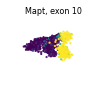

In [71]:
fig = plt.figure(figsize=(4/2.4, 3/2.5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, 
           c=tiklova_PSI.loc['Mapt_1'], alpha=0.9, s=5, linewidth=0)


ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.axis("off")

ax.grid(False)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Mapt, exon 10', fontsize=8)

plt.savefig('simulations/plots/Mapt_1_sc.png', bbox_inches='tight', res=20000, dpi =2000)

/mnt/lareaulab/cfbuenabadn/.local/lib/python3.7/site-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


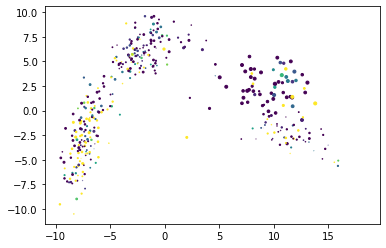

In [77]:
plt.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=tiklova_PSI.loc['Gria2_2'])

# Hasta aqui de ayer

In [12]:
from sklearn.metrics import auc
from sklearn.metrics import f1_score

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.01)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.01)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
briep_auc = []
brie_l_auc = []

for sample in tqdm(range(200)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_gearyc.index) + [0]*len(pd.Index(neg_choice) & tiklova_gearyc.index)
    c_y = list((tiklova_gearyc.loc[pd.Index(pos_choice) & tiklova_gearyc.index].qvals <= 0.05).astype(int)) + list((tiklova_gearyc.loc[pd.Index(neg_choice) & tiklova_gearyc.index].qvals <= 0.05).astype(int))
    f1 = f1_score(y, c_y)
    gearyc_auc.append(f1)

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list((tiklova_psix.loc[pos_choice].qvals <= 0.05).astype(int)) + list((tiklova_psix.loc[neg_choice].qvals <= 0.05).astype(int))
    psix_auc.append(f1_score(y, psix_y))
    

    kw_y = list((tiklova_kw.loc[pos_choice].qvals <= 0.05).astype(int)) + list((tiklova_kw.loc[neg_choice].qvals <= 0.05).astype(int))
    kw_auc.append(f1_score(y, kw_y))
    

    r_y = list((tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]<=0.05).astype(int)) + list((tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]]<=0.05).astype(int))
    brie_l_auc.append(f1_score([1]*len([x for x in pos_choice if x in tiklova_ovo.index]) + [0]*len([x for x in neg_choice if x in tiklova_ovo.index]), r_y))
    #####




100%|██████████| 200/200 [00:04<00:00, 41.44it/s]


Text(0.5, 1.0, 'Method comparison, Tiklova dataset')

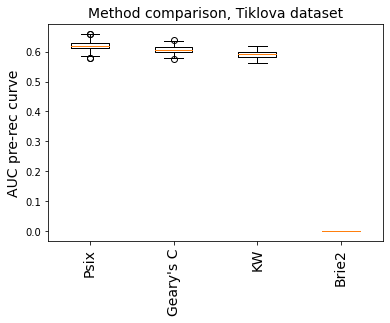

In [13]:
tiklova_boxplots = [ psix_auc, gearyc_auc, kw_auc, brie_l_auc]

# kw_auc = []
# psix_auc = []
# gearyc_auc = []
# briep_auc = []
# brie_l_auc = []

bp = plt.boxplot(tiklova_boxplots)


plt.xticks(np.arange(1, 5), 
           ['Psix', "Geary's C", 'KW', 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Tiklova dataset', fontsize=14)

In [14]:
one_v_one = 'mouse_brain_development/brie2/'
tiklova_0v1 = pd.read_csv(one_v_one + 'brie_output_E13_v_E15/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v2 = pd.read_csv(one_v_one + 'brie_output_E13_v_E18/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v3 = pd.read_csv(one_v_one + 'brie_output_E13_v_P1/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v4 = pd.read_csv(one_v_one + 'brie_output_E13_v_P7/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v5 = pd.read_csv(one_v_one + 'brie_output_E13_v_P90/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)

tiklova_one_v_one = pd.DataFrame()
tiklova_one_v_one['0v1'] = tiklova_0v1.neuro_pval
tiklova_one_v_one['0v2'] = tiklova_0v2.neuro_pval
tiklova_one_v_one['0v3'] = tiklova_0v3.neuro_pval
tiklova_one_v_one['0v4'] = tiklova_0v4.neuro_pval
tiklova_one_v_one['0v5'] = tiklova_0v5.neuro_pval
tiklova_ovo = tiklova_one_v_one.min(axis=1)

In [15]:
neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.01) | (weyn_fdr.min(axis=1) > 0.1)] & tiklova_psix.index & tiklova_ovo.index


In [16]:
plt.hist(tiklova_psix.loc[weyn_neg].pvals)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

(array([225.,  40.,  30.,  20.,  14.,  13.,   8.,   5.,   4.,   3.]),
 array([7.994e-32, 3.580e-02, 7.160e-02, 1.074e-01, 1.432e-01, 1.790e-01,
        2.148e-01, 2.506e-01, 2.864e-01, 3.222e-01, 3.580e-01]),
 <a list of 10 Patch objects>)

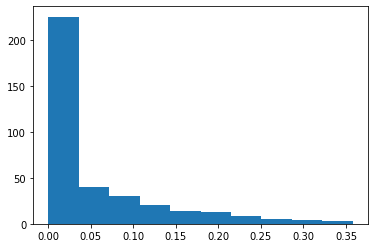

In [33]:
plt.hist(tiklova_ovo.loc[weyn_neg])

(array([193.,  36.,  25.,  16.,  25.,  17.,  17.,  15.,   8.,  10.]),
 array([7.39830480e-30, 9.84774149e-02, 1.96954830e-01, 2.95432245e-01,
        3.93909660e-01, 4.92387075e-01, 5.90864490e-01, 6.89341905e-01,
        7.87819320e-01, 8.86296734e-01, 9.84774149e-01]),
 <a list of 10 Patch objects>)

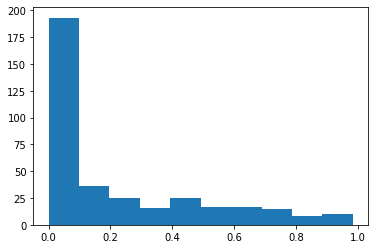

In [34]:
plt.hist(tiklova_kw.loc[weyn_neg].pvals)

(-0.5, 10.0)

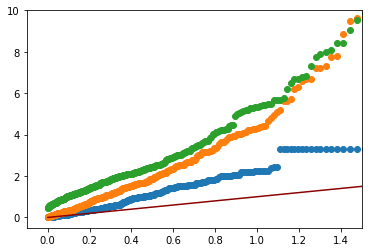

In [47]:
plt.scatter(sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))),
            sorted(-np.log10(tiklova_psix.loc[weyn_neg].pvals)))

plt.scatter(sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))),
            sorted(-np.log10(tiklova_kw.loc[weyn_neg].pvals)))

plt.scatter(sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))),
            sorted(-np.log10(tiklova_ovo.loc[weyn_neg])))




plt.plot(sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))),
            sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))), c='darkred')

plt.xlim((-0.1, 1.5))
plt.ylim((-0.5, 10))

In [30]:
common_idx = tiklova_psix.index & tiklova_ovo.index & weyn_pos
tiklova_psix.loc[common_idx].loc[(tiklova_psix.loc[common_idx].qvals >= 0.1) & (tiklova_ovo.loc[common_idx]<=0.01)]

,psix_score,pvals,qvals
Hmgn3_3,0.021581,0.097951,0.181872
Deaf1_nmdSE_3,0.013916,0.055472,0.116236
Scnm1_1,0.013813,0.055472,0.116236
Gabpb1_4,0.013563,0.060970,0.125859
Rnf146_4,0.012885,0.062469,0.127691
...,...,...,...
Fam118b_2,-0.028730,0.814093,0.889070
Repin1_1,-0.029305,0.834583,0.902941
N6amt1_1,-0.033029,0.837081,0.905176
Flot2_1,-0.041104,0.915042,0.952036


In [23]:
rd = pd.read_csv('mouse_brain_development/data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)

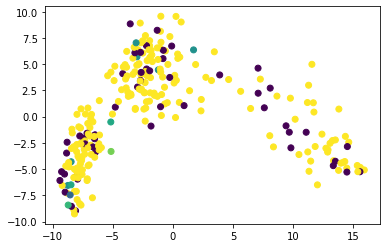

In [33]:
plt.scatter(rd.PC_1, rd.PC_2, c=tiklova_PSI.loc['Pbrm1_17'])

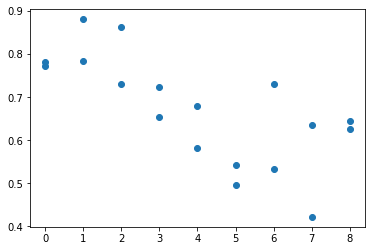

In [34]:
plt.scatter([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8], 
            weyn_psi.loc['Pbrm1_17'])

In [49]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

In [50]:
tiklova_one_v_one = pd.DataFrame()
tiklova_one_v_one['0v1'] = tiklova_0v1.neuro_ELBO_gain
tiklova_one_v_one['0v2'] = tiklova_0v2.neuro_ELBO_gain
tiklova_one_v_one['0v3'] = tiklova_0v3.neuro_ELBO_gain
tiklova_one_v_one['0v4'] = tiklova_0v4.neuro_ELBO_gain
tiklova_one_v_one['0v5'] = tiklova_0v5.neuro_ELBO_gain
tiklova_ovo = tiklova_one_v_one.max(axis=1)

100%|██████████| 500/500 [00:08<00:00, 57.99it/s]


Text(0.5, 1.0, 'Method comparison, Tiklova dataset')

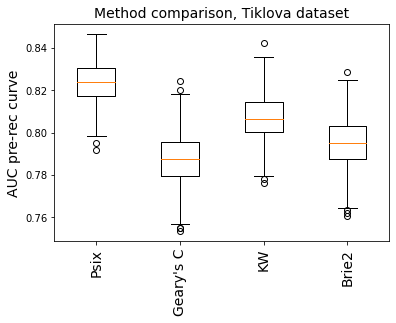

In [65]:


weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.01)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.01) | (weyn_fdr.min(axis=1) > 0.01)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
briep_auc = []
brie_l_auc = []

for sample in tqdm(range(500)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_gearyc.index) + [0]*len(pd.Index(neg_choice) & tiklova_gearyc.index)
    c_y = list(tiklova_gearyc.loc[pd.Index(pos_choice) & tiklova_gearyc.index].C_score) + list(tiklova_gearyc.loc[pd.Index(neg_choice) & tiklova_gearyc.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    gearyc_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].psix_score) + list(tiklova_psix.loc[neg_choice].psix_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    psix_auc.append(auc(rec, pre))
    

    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    

    r_y = list(tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]) + list(tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]])
    pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in tiklova_ovo.index]) + [0]*len([x for x in neg_choice if x in tiklova_ovo.index]), r_y)
    brie_l_auc.append(auc(rec, pre))
    #####

tiklova_boxplots = [ psix_auc, gearyc_auc, kw_auc, brie_l_auc]

# kw_auc = []
# psix_auc = []
# gearyc_auc = []
# briep_auc = []
# brie_l_auc = []

bp = plt.boxplot(tiklova_boxplots)


plt.xticks(np.arange(1, 5), 
           ['Psix', "Geary's C", 'KW', 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Tiklova dataset', fontsize=14)


100%|██████████| 500/500 [00:09<00:00, 55.20it/s]


Text(0.5, 1.0, 'Method comparison, Tiklova dataset')

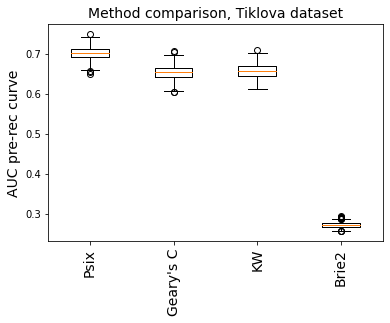

In [11]:


weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.01)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.01)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
psix_auc = []
gearyc_auc = []
briep_auc = []
brie_l_auc = []

for sample in tqdm(range(500)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_gearyc.index) + [0]*len(pd.Index(neg_choice) & tiklova_gearyc.index)
    c_y = list(tiklova_gearyc.loc[pd.Index(pos_choice) & tiklova_gearyc.index].C_score) + list(tiklova_gearyc.loc[pd.Index(neg_choice) & tiklova_gearyc.index].C_score)
    pre, rec, thres = precision_recall_curve(y, c_y)
    gearyc_auc.append(auc(rec, pre))

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].psix_score) + list(tiklova_psix.loc[neg_choice].psix_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    psix_auc.append(auc(rec, pre))
    

    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    

    r_y = list(tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]) + list(tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]])
    pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in tiklova_ovo.index]) + [0]*len([x for x in neg_choice if x in tiklova_ovo.index]), r_y)
    brie_l_auc.append(auc(rec, pre))
    #####

tiklova_boxplots = [ psix_auc, gearyc_auc, kw_auc, brie_l_auc]

# kw_auc = []
# psix_auc = []
# gearyc_auc = []
# briep_auc = []
# brie_l_auc = []

bp = plt.boxplot(tiklova_boxplots)


plt.xticks(np.arange(1, 5), 
           ['Psix', "Geary's C", 'KW', 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison, Tiklova dataset', fontsize=14)
